In [1]:
using Random

In [2]:
using BenchmarkTools

In [1]:
####### 1d Ising
# Metropolis

In [ ]:
mutable type Measurements
    configurations::Confs # first two dim = conf, third dim = n_conf
    energies::Array{Float64, 1}
    magnetization::Array{Float64, 1}
    
    Measurements() = new()
end

In [13]:
# Wrap everything with a module to allow redefition of type
module MC

"""
Composite type to represent a spin state
"""
mutable struct SpinState
    num_spins::Int
    s::Array{Int8,1}
    energy::Int
    tot_mag::Int
end

"""
Energy
"""
function energy(s)
    n = length(s)
    - sum((s[i] * s[ifelse(i == n, 1, i+1)] for i in 1:n))
end

"""
Total magnetization
"""
total_magnetization(s) = sum(s)

"""
Constructor
"""
function SpinState(s)
    ss = SpinState(length(s), copy(s), energy(s), total_magnetization(s))
    sanity_check(ss)
    ss
end

"""
Sanity check
"""
function sanity_check(ss)
    @assert energy(ss.s) == ss.energy
    @assert total_magnetization(ss.s) == ss.tot_mag
end

"""
Take an object of SpinState as an input and update it in place.
"""
function update!(ss, β, niters)
    min_h = -2
    max_h = 2
    s = ss.s
    n = ss.num_spins
    prob = [1/(1+exp(-2*β*h)) for h in min_h:max_h]
    for iter in 1:niters, i in 1:n
        sl = s[ifelse(i == 1, n, i-1)]
        sr = s[ifelse(i == n, 1, i+1)]
        # h = -2, 0, 2
        h = sl + sr
        si_old = s[i]
        s[i] = ifelse(rand() < prob[h-min_h+1], +1, -1)
        
        # Update observables with O(1) operations
        ss.energy += (si_old - s[i]) * h
        ss.tot_mag += (s[i] - si_old)
    end
end

end
;

In [14]:
ss = MC.SpinState(s0)
MC.update!(ss, β, niters)
MC.sanity_check(ss)

In [9]:
num_spins = 100
s0 = rand(Int8[-1, 1], num_spins)
β = 10.0
niters = 10^3

s = copy(s0)

100-element Vector{Int8}:
 -1
  1
  1
  1
  1
 -1
  1
 -1
 -1
 -1
 -1
  1
 -1
  ⋮
 -1
 -1
  1
 -1
  1
 -1
 -1
  1
  1
  1
 -1
 -1

In [26]:
nsweeps = 10^6
num_spins = 100

s0 = rand(Int8[-1, 1], num_spins)

Ts_mc = range(0.4, 2, length=10)

C_mc = Float64[]
for T in Ts_mc
    ss = MC.SpinState(s0)
    acc = Meas.Accumulator()
    solve!(ss, acc, 1/T, nsweeps, ntherm, interval_meas)
    E = Meas.mean(acc, "E")
    E2 = Meas.mean(acc, "E2")
    push!(C_mc, (E2-E^2)/T^2)
end

In [16]:
module Meas

struct Accumulator
    count::Dict{String,UInt64}
    data::Dict{String,Any}
end

"""
Constructor
"""
function Accumulator()
    Accumulator(Dict{String,UInt64}(), Dict{String,Any}())
end

"""
Add a sample
"""
function add!(acc::Accumulator, name::String, data)
    if haskey(acc.count, name)
        acc.count[name] += 1
        acc.data[name] += data
    else
        acc.count[name] = 1
        acc.data[name] = copy(data)
    end
end

"""
Compuate mean
"""
function mean(acc::Accumulator, name::String)
    return acc.data[name]/acc.count[name]
end

end


# Perform some tests
let
    acc = Meas.Accumulator()
    Meas.add!(acc, "obs1", ones(4))
    Meas.add!(acc, "obs1", fill(2.0, 4))
    Meas.add!(acc, "obs2", ones(4))
    Meas.add!(acc, "obs2", ones(4))
    @assert Meas.mean(acc, "obs1") ≈ fill(1.5, 4)
    @assert Meas.mean(acc, "obs2") ≈ ones(4)
end

In [25]:
function solve!(ss, acc, β, nsweeps, ntherm, interval_meas)
    if mod(nsweeps, interval_meas) != 0
        error("nsweeps cannot be divided by interval_meas!")
    end
    
    # Thermalization steps
    MC.update!(ss, β, ntherm)
    
    # Measurement steps
    for imeas in 1:(nsweeps÷interval_meas)
        MC.update!(ss, β, interval_meas)
        Meas.add!(acc, "E", Float64(ss.energy))
        Meas.add!(acc, "E2", Float64(ss.energy)^2)
    end
    MC.sanity_check(ss)
end

nsweeps = 100
interval_meas = 10
ntherm = nsweeps÷10
β = 1.0

1.0

In [27]:
using Plots

[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
┌ Warning: backend `GR` is not installed.
└ @ Plots ~/.julia/packages/Plots/tDHxD/src/backends.jl:43


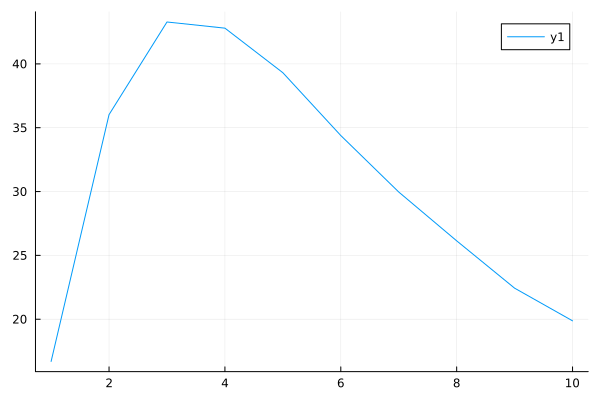

In [28]:
plot(C_mc)

In [36]:
s0 = rand(Int8[-1, 1], num_spins)

solve!(s0, 0, 1/2, 10^3, nsweeps÷10, 10)

LoadError: type Array has no field s

In [ ]:
heatmap()

In [2]:
# Wolff

In [3]:
######### 2d Ising